# Data_Understanding_EDA

EDA for PAKDD2010 modeling dataset

In [14]:
# ============================
# ✅ 02 - Data Understanding / EDA
# Cargar dataset + inspección inicial
# ============================

import pandas as pd
import numpy as np

# Paths
path_vars = "../data/raw/PAKDD2010_VariablesList.XLS"
path_model = "../data/raw/PAKDD2010_Modeling_Data.txt"
path_pred = "../data/raw/PAKDD2010_Prediction_Data.txt"

# 1️⃣ Cargar variables desde Excel (PAKDD2010_VariablesList.XLS)
try:
    df_vars = pd.read_excel(path_vars)
    print(f"✅ Archivo de columnas leído correctamente desde Excel: {path_vars}")
except Exception as e:
    raise ValueError(f"No se pudo leer la lista de variables desde {path_vars}: {e}")

# Ajustar nombre columna 43 si es necesario
colnames = df_vars['Var_Title'].astype(str).tolist()
if len(colnames) > 43:
    colnames[43] = "MATE_" + colnames[43]

# 2️⃣ Cargar datasets
df_model = pd.read_csv(path_model, sep="\t", header=None, names=colnames,
                       encoding='latin1', low_memory=False)
df_pred = pd.read_csv(path_pred, sep="\t", header=None, names=colnames[:-1],
                      encoding='latin1', low_memory=False)

print("✅ Datos cargados correctamente\n")

# 3️⃣ Dimensiones iniciales
print(f"📌 df_model (Modeling) → {df_model.shape}")
print(f"📌 df_pred (Prediction) → {df_pred.shape}")

df_model.head()

✅ Archivo de columnas leído correctamente desde Excel: ../data/raw/PAKDD2010_VariablesList.XLS
✅ Datos cargados correctamente

📌 df_model (Modeling) → (50000, 54)
📌 df_pred (Prediction) → (20000, 53)
✅ Datos cargados correctamente

📌 df_model (Modeling) → (50000, 54)
📌 df_pred (Prediction) → (20000, 53)


,ID_CLIENT,CLERK_TYPE,PAYMENT_DAY,APPLICATION_SUBMISSION_TYPE,QUANT_ADDITIONAL_CARDS,POSTAL_ADDRESS_TYPE,SEX,MARITAL_STATUS,QUANT_DEPENDANTS,EDUCATION_LEVEL,STATE_OF_BIRTH,CITY_OF_BIRTH,NACIONALITY,RESIDENCIAL_STATE,RESIDENCIAL_CITY,RESIDENCIAL_BOROUGH,FLAG_RESIDENCIAL_PHONE,RESIDENCIAL_PHONE_AREA_CODE,RESIDENCE_TYPE,MONTHS_IN_RESIDENCE,FLAG_MOBILE_PHONE,FLAG_EMAIL,PERSONAL_MONTHLY_INCOME,OTHER_INCOMES,FLAG_VISA,FLAG_MASTERCARD,FLAG_DINERS,FLAG_AMERICAN_EXPRESS,FLAG_OTHER_CARDS,QUANT_BANKING_ACCOUNTS,QUANT_SPECIAL_BANKING_ACCOUNTS,PERSONAL_ASSETS_VALUE,QUANT_CARS,COMPANY,PROFESSIONAL_STATE,PROFESSIONAL_CITY,PROFESSIONAL_BOROUGH,FLAG_PROFESSIONAL_PHONE,PROFESSIONAL_PHONE_AREA_CODE,MONTHS_IN_THE_JOB,PROFESSION_CODE,OCCUPATION_TYPE,MATE_PROFESSION_CODE,MATE_EDUCATION_LEVEL,FLAG_HOME_ADDRESS_DOCUMENT,FLAG_RG,FLAG_CPF,FLAG_INCOME_PROOF,PRODUCT,FLAG_ACSP_RECORD,AGE,RESIDENCIAL_ZIP_3,PROFESSIONAL_ZIP_3,TARGET_LABEL_BAD=1
0,1,C,5,Web,0,1,F,6,1,0,RN,Assu,1,RN,Santana do Matos,Centro,Y,105,1.0,15.0,N,1,900.0,0.0,1,1,0,0,0,0,0,0.0,0,N,,NaN,NaN,N,,0,9.0,4.0,NaN,NaN,0,0,0,0,1,N,32,595,595,1
1,2,C,15,Carga,0,1,F,2,0,0,RJ,rio de janeiro,1,RJ,RIO DE JANEIRO,CAMPO GRANDE,Y,20,1.0,1.0,N,1,750.0,0.0,0,0,0,0,0,0,0,0.0,0,Y,,NaN,NaN,N,,0,11.0,4.0,11.0,NaN,0,0,0,0,1,N,34,230,230,1
2,3,C,5,Web,0,1,F,2,0,0,RN,GARANHUNS,1,RN,Parnamirim,Boa Esperanca,Y,105,1.0,NaN,N,1,500.0,0.0,0,0,0,0,0,0,0,0.0,0,N,,NaN,NaN,N,,0,11.0,NaN,NaN,NaN,0,0,0,0,1,N,27,591,591,0
3,4,C,20,Web,0,1,F,2,0,0,PE,CABO,1,PE,CABO,PONTE DOS CARVALHOS,N,,NaN,NaN,N,1,500.0,0.0,0,0,0,0,0,0,0,0.0,0,N,,NaN,NaN,N,,0,NaN,NaN,NaN,NaN,0,0,0,0,1,N,61,545,545,0
4,5,C,10,Web,0,1,M,2,0,0,RJ,RIO DE JANEIRO,1,RJ,Rio de Janeiro,Santa Cruz,Y,20,1.0,12.0,N,1,1200.0,0.0,0,0,0,0,0,0,0,0.0,0,N,,NaN,NaN,N,,0,9.0,5.0,NaN,NaN,0,0,0,0,1,N,48,235,235,1


In [15]:
# ============================
# ✅ 2: Perfil de datos y limpieza inicial de estructura
# ============================

# 1️⃣ Identificar variables numéricas vs categóricas
num_features = df_model.select_dtypes(include=[np.number]).columns.tolist()
cat_features = df_model.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"Variables numéricas: {len(num_features)}")
print(f"Variables categóricas: {len(cat_features)}")

# 2️⃣ Contar valores únicos por variable
unique_counts = df_model.nunique().sort_values()

# 3️⃣ Detectar variables con un solo valor → No aportan al modelo
single_value_cols = unique_counts[unique_counts <= 1].index.tolist()
print(f"❌ Variables con un solo valor: {len(single_value_cols)}")
print(single_value_cols)

# Eliminarlas por ahora del dataset de análisis (NO borramos del original)
df_eda = df_model.drop(columns=single_value_cols)

print(f"✅ df_eda shape después de remover columnas con valores únicos: {df_eda.shape}")

# 4️⃣ Resumen de nulos
missing_df = df_eda.isnull().sum().reset_index()
missing_df.columns = ["feature", "missing"]
missing_df["missing_pct"] = (missing_df["missing"] / len(df_eda)) * 100

missing_df = missing_df.sort_values(by="missing_pct", ascending=False)

print("📌 Top variables con + valores nulos:")
display(missing_df.head(10))

# 5️⃣ Vista general de calidad de datos
quality_summary = pd.DataFrame({
    "feature": df_eda.columns,
    "dtype": df_eda.dtypes.values,
    "unique": df_eda.nunique().values,
})
quality_summary = quality_summary.merge(missing_df, on="feature")

display(quality_summary.head(20))


Variables numéricas: 34
Variables categóricas: 20
❌ Variables con un solo valor: 9
['CLERK_TYPE', 'QUANT_ADDITIONAL_CARDS', 'EDUCATION_LEVEL', 'FLAG_MOBILE_PHONE', 'FLAG_INCOME_PROOF', 'FLAG_CPF', 'FLAG_RG', 'FLAG_HOME_ADDRESS_DOCUMENT', 'FLAG_ACSP_RECORD']
✅ df_eda shape después de remover columnas con valores únicos: (50000, 45)
📌 Top variables con + valores nulos:
❌ Variables con un solo valor: 9
['CLERK_TYPE', 'QUANT_ADDITIONAL_CARDS', 'EDUCATION_LEVEL', 'FLAG_MOBILE_PHONE', 'FLAG_INCOME_PROOF', 'FLAG_CPF', 'FLAG_RG', 'FLAG_HOME_ADDRESS_DOCUMENT', 'FLAG_ACSP_RECORD']
✅ df_eda shape después de remover columnas con valores únicos: (50000, 45)
📌 Top variables con + valores nulos:


,feature,missing,missing_pct
31,PROFESSIONAL_CITY,33783,67.566
32,PROFESSIONAL_BOROUGH,33783,67.566
39,MATE_EDUCATION_LEVEL,32338,64.676
38,MATE_PROFESSION_CODE,28884,57.768
36,PROFESSION_CODE,7756,15.512
37,OCCUPATION_TYPE,7313,14.626
16,MONTHS_IN_RESIDENCE,3777,7.554
15,RESIDENCE_TYPE,1349,2.698
0,ID_CLIENT,0,0.000
1,PAYMENT_DAY,0,0.000


,feature,dtype,unique,missing,missing_pct
0,ID_CLIENT,int64,50000,0,0.000
1,PAYMENT_DAY,int64,6,0,0.000
2,APPLICATION_SUBMISSION_TYPE,object,3,0,0.000
3,POSTAL_ADDRESS_TYPE,int64,2,0,0.000
4,SEX,object,4,0,0.000
5,MARITAL_STATUS,int64,8,0,0.000
6,QUANT_DEPENDANTS,int64,17,0,0.000
7,STATE_OF_BIRTH,object,29,0,0.000
8,CITY_OF_BIRTH,object,9910,0,0.000
9,NACIONALITY,int64,3,0,0.000


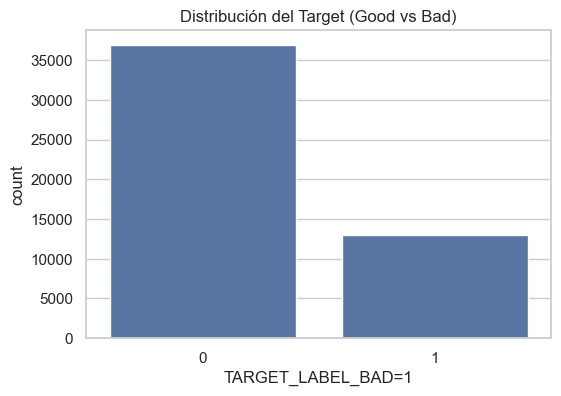

📌 Porcentaje de cada clase:
TARGET_LABEL_BAD=1
0    73.918
1    26.082
Name: proportion, dtype: float64

⚠️ Default rate: 26.08%

📌 Distribución por SEX


SEX
F    30805
M    19130
N       48
        17
Name: count, dtype: int64


📌 Distribución por MARITAL_STATUS


MARITAL_STATUS
2    25967
1    15286
4     4206
6     1877
5     1296
3      632
7      534
0      202
Name: count, dtype: int64


📌 Distribución por RESIDENCE_TYPE


RESIDENCE_TYPE
1.0    41572
2.0     3884
5.0     1983
0.0      760
4.0      311
3.0      141
Name: count, dtype: int64


📌 Distribución por APPLICATION_SUBMISSION_TYPE


APPLICATION_SUBMISSION_TYPE
Web      28206
0        19461
Carga     2333
Name: count, dtype: int64


📌 Distribución por POSTAL_ADDRESS_TYPE


POSTAL_ADDRESS_TYPE
1    49673
2      327
Name: count, dtype: int64

In [16]:
# ============================
# ✅ 3: EDA del Target
# ============================

import matplotlib.pyplot as plt
import seaborn as sns

target_col = "TARGET_LABEL_BAD=1"

# 1️⃣ Distribución del Target
plt.figure(figsize=(6,4))
sns.countplot(x=target_col, data=df_eda)
plt.title("Distribución del Target (Good vs Bad)")
plt.show()

# 2️⃣ Porcentaje de incumplimiento
target_rate = df_eda[target_col].value_counts(normalize=True) * 100
print("📌 Porcentaje de cada clase:")
print(target_rate)

default_rate = target_rate.get(1, 0)
print(f"\n⚠️ Default rate: {default_rate:.2f}%")

# 3️⃣ Conteos simples por algunas variables claves
features_check = [
    "SEX", "MARITAL_STATUS", "RESIDENCE_TYPE", 
    "APPLICATION_SUBMISSION_TYPE", "POSTAL_ADDRESS_TYPE"
]

for col in features_check:
    if col in df_eda.columns:
        print(f"\n📌 Distribución por {col}")
        display(df_eda[col].value_counts())



📌 Análisis Target vs SEX


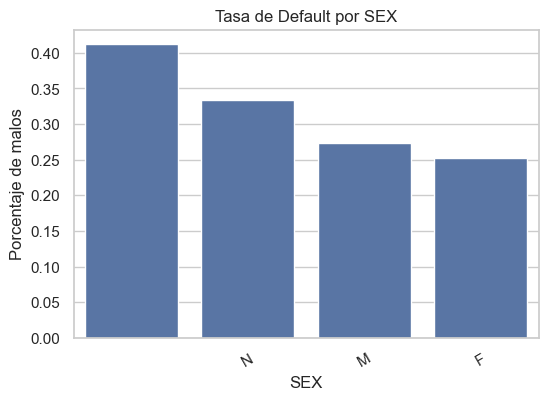

SEX
     0.411765
N    0.333333
M    0.273288
F    0.252881
Name: TARGET_LABEL_BAD=1, dtype: float64


📌 Análisis Target vs MARITAL_STATUS


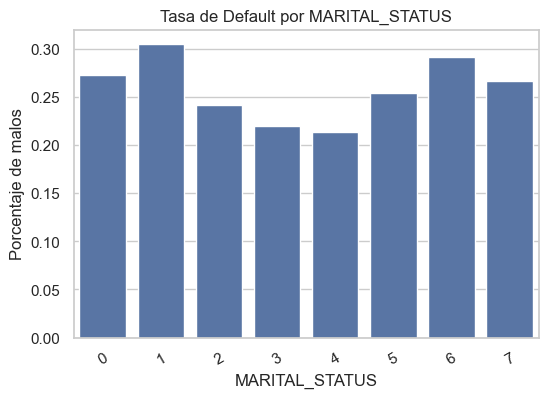

MARITAL_STATUS
1    0.304527
6    0.291422
0    0.272277
7    0.265918
5    0.253858
2    0.241730
3    0.219937
4    0.213267
Name: TARGET_LABEL_BAD=1, dtype: float64


📌 Análisis Target vs RESIDENCE_TYPE


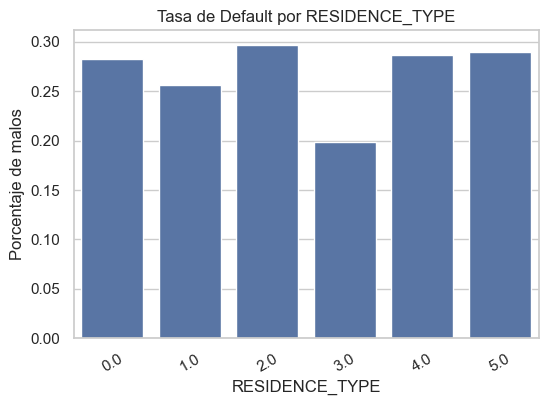

RESIDENCE_TYPE
2.0    0.296601
5.0    0.289965
4.0    0.286174
0.0    0.282895
1.0    0.256086
3.0    0.198582
Name: TARGET_LABEL_BAD=1, dtype: float64


📌 Análisis Target vs APPLICATION_SUBMISSION_TYPE


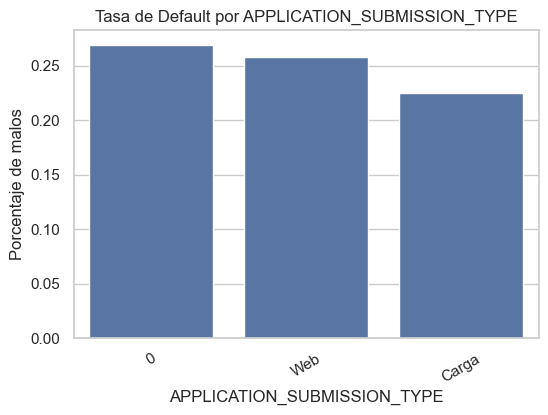

APPLICATION_SUBMISSION_TYPE
0        0.269102
Web      0.258101
Carga    0.224604
Name: TARGET_LABEL_BAD=1, dtype: float64

In [17]:
# ============================
# ✅ 4: Gráficos Target vs Variables clave
# ============================

def plot_target_rate(df, col, target=target_col, rotation=0):
    plt.figure(figsize=(6,4))
    rate = df.groupby(col)[target].mean().sort_values(ascending=False)
    sns.barplot(x=rate.index, y=rate.values)
    plt.title(f"Tasa de Default por {col}")
    plt.ylabel("Porcentaje de malos")
    plt.xticks(rotation=rotation)
    plt.show()
    display(rate)

# Variables categóricas clave para riesgo
cat_to_plot = [
    "SEX", "MARITAL_STATUS", "RESIDENCE_TYPE",
    "APPLICATION_SUBMISSION_TYPE"
]

for col in cat_to_plot:
    if col in df_eda.columns:
        print(f"\n📌 Análisis Target vs {col}")
        plot_target_rate(df_eda, col, rotation=30)


📌 Correlaciones con el Target (Top 15)


TARGET_LABEL_BAD=1                1.000000
PAYMENT_DAY                       0.070633
OCCUPATION_TYPE                   0.040216
PRODUCT                           0.019293
RESIDENCE_TYPE                    0.019168
QUANT_DEPENDANTS                  0.012157
QUANT_SPECIAL_BANKING_ACCOUNTS    0.011997
QUANT_BANKING_ACCOUNTS            0.011997
QUANT_CARS                        0.011706
ID_CLIENT                         0.010509
OTHER_INCOMES                     0.004442
PERSONAL_MONTHLY_INCOME           0.002819
FLAG_DINERS                       0.002240
FLAG_OTHER_CARDS                  0.001410
FLAG_AMERICAN_EXPRESS             0.000337
Name: TARGET_LABEL_BAD=1, dtype: float64

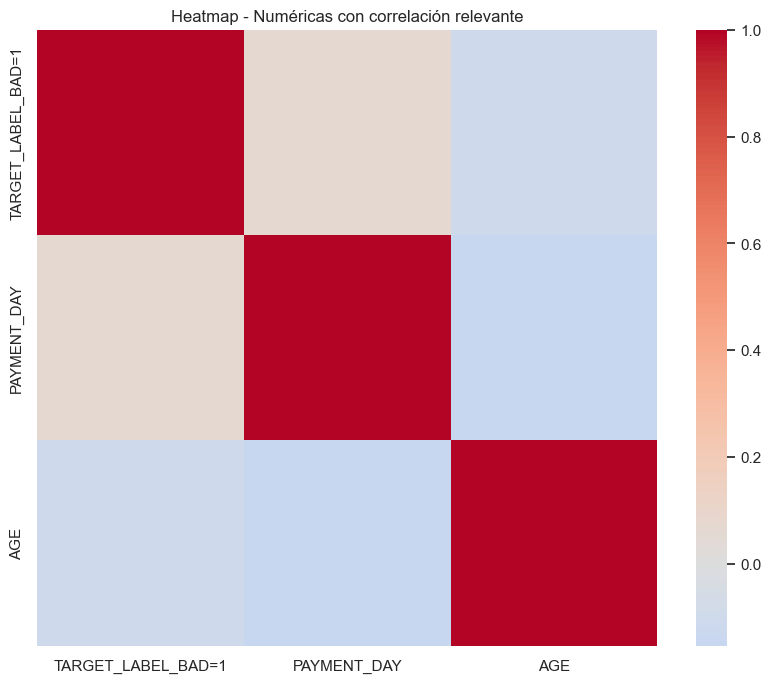

In [18]:
# ============================
# ✅ Celda 5: Correlación numérica y visualización (fix)
# ============================

# ✅ Reidentificar variables numéricas después de la eliminación de columnas
num_features = df_eda.select_dtypes(include=[np.number]).columns.tolist()

# Mantener solo numéricas
df_num = df_eda[num_features]

# 📌 Matriz de correlación con el target
corr_target = df_num.corr()[target_col].sort_values(ascending=False)

print("📌 Correlaciones con el Target (Top 15)")
display(corr_target.head(15))

# 🎯 Heatmap (solo variables con correlación > 0.05y)
important_num_feats = corr_target[abs(corr_target) > 0.05].index.tolist()

plt.figure(figsize=(10, 8))
sns.heatmap(df_num[important_num_feats].corr(), cmap="coolwarm", center=0, annot=False)
plt.title("Heatmap - Numéricas con correlación relevante")
plt.show()


In [19]:
# ============================
# ✅ Celda 6: Clasificación avanzada SIN unique_value
# ============================

df_clean = df_eda.copy()

# Renombrar la columna target si es necesario
if "TARGET_LABEL_BAD=1" in df_clean.columns:
    df_clean = df_clean.rename(columns={"TARGET_LABEL_BAD=1": "TARGET"})

target_col = "TARGET"
assigned = {target_col}

# 1️⃣ Binarias (Y/N, 0/1, etc.)
binary_flags = []
valid_flags = {"0","1","Y","N","YES","NO","SI","TRUE","FALSE","T","F"}
for col in df_clean.columns:
    if col in assigned: continue
    vals = set(str(v).upper().strip() for v in df_clean[col].dropna().unique())
    if len(vals) <= 2 and vals.issubset(valid_flags):
        binary_flags.append(col)
        assigned.add(col)

# 2️⃣ Numéricas reales → >30 valores únicos y no binarias
num_reales = []
others_numeric_for_categorization = []

for col in df_clean.select_dtypes(include=["number"]).columns:
    if col in assigned: continue
    if df_clean[col].nunique() > 30:
        num_reales.append(col)
    else:
        others_numeric_for_categorization.append(col)
    assigned.add(col)

# 3️⃣ Categóricas → baja vs alta cardinalidad
cat_low, cat_high = [], []
for col in df_clean.select_dtypes(include=["object"]).columns:
    if col in assigned: continue
    n_unique = df_clean[col].nunique()
    if n_unique <= 30:
        cat_low.append(col)
    else:
        cat_high.append(col)
    assigned.add(col)

# 4️⃣ Posibles textos libres o alto missing
text_vars = [
    col for col in cat_high
    if df_clean[col].isna().mean() > 0.70 or
       df_clean[col].astype(str).apply(len).mean() > 30
]

print("\n✅ Clasificación final de variables (sin unique_value)")
print("-----------------------------------------------------")
print(f"Binary flags ✅ OneHot: {len(binary_flags)}")
print(f"Num_reales ✅ escalado/binning: {len(num_reales)}")
print(f"Cat_low ✅ OneHot: {len(cat_low)}")
print(f"Cat_high ✅ Target Enc.: {len(cat_high)}")
print(f"Texto libre ❌ revisar: {len(text_vars)}")

# ✅ Diccionario final para el pipeline
feature_groups = {
    "target": target_col,
    "binary_flags": binary_flags,
    "num_reales": num_reales,
    "cat_low": cat_low,
    "cat_high": cat_high,
    "text_vars": text_vars
}

feature_groups



✅ Clasificación final de variables (sin unique_value)
-----------------------------------------------------
Binary flags ✅ OneHot: 10
Num_reales ✅ escalado/binning: 6
Cat_low ✅ OneHot: 5
Cat_high ✅ Target Enc.: 9
Texto libre ❌ revisar: 0


{'target': 'TARGET',
 'binary_flags': ['FLAG_RESIDENCIAL_PHONE',
  'FLAG_EMAIL',
  'FLAG_VISA',
  'FLAG_MASTERCARD',
  'FLAG_DINERS',
  'FLAG_AMERICAN_EXPRESS',
  'FLAG_OTHER_CARDS',
  'QUANT_CARS',
  'COMPANY',
  'FLAG_PROFESSIONAL_PHONE'],
 'num_reales': ['ID_CLIENT',
  'MONTHS_IN_RESIDENCE',
  'PERSONAL_MONTHLY_INCOME',
  'OTHER_INCOMES',
  'PERSONAL_ASSETS_VALUE',
  'AGE'],
 'cat_low': ['APPLICATION_SUBMISSION_TYPE',
  'SEX',
  'STATE_OF_BIRTH',
  'RESIDENCIAL_STATE',
  'PROFESSIONAL_STATE'],
 'cat_high': ['CITY_OF_BIRTH',
  'RESIDENCIAL_CITY',
  'RESIDENCIAL_BOROUGH',
  'RESIDENCIAL_PHONE_AREA_CODE',
  'PROFESSIONAL_CITY',
  'PROFESSIONAL_BOROUGH',
  'PROFESSIONAL_PHONE_AREA_CODE',
  'RESIDENCIAL_ZIP_3',
  'PROFESSIONAL_ZIP_3'],
 'text_vars': []}

📊 Variables numéricas reales a analizar: 6



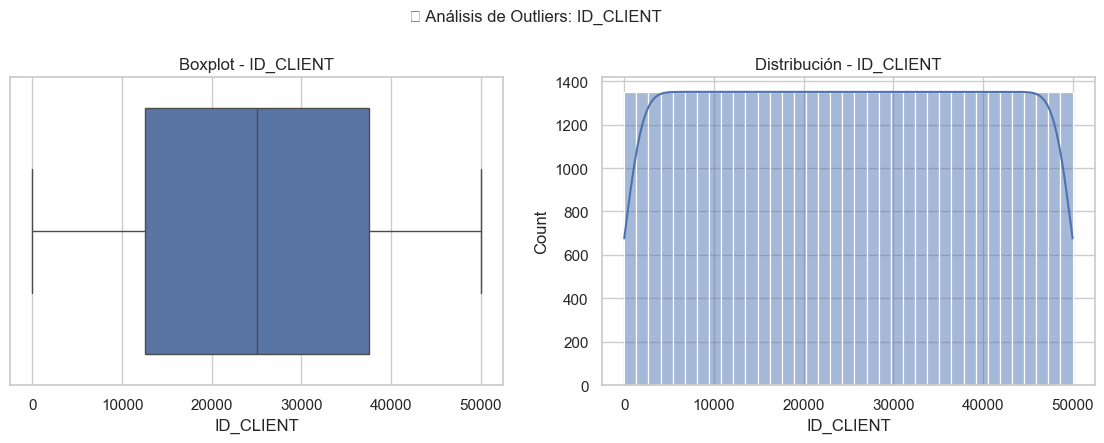

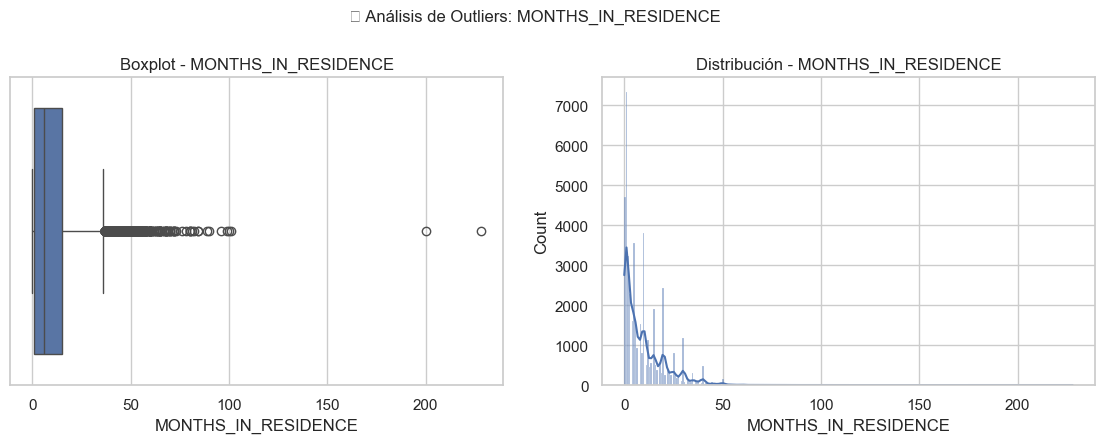

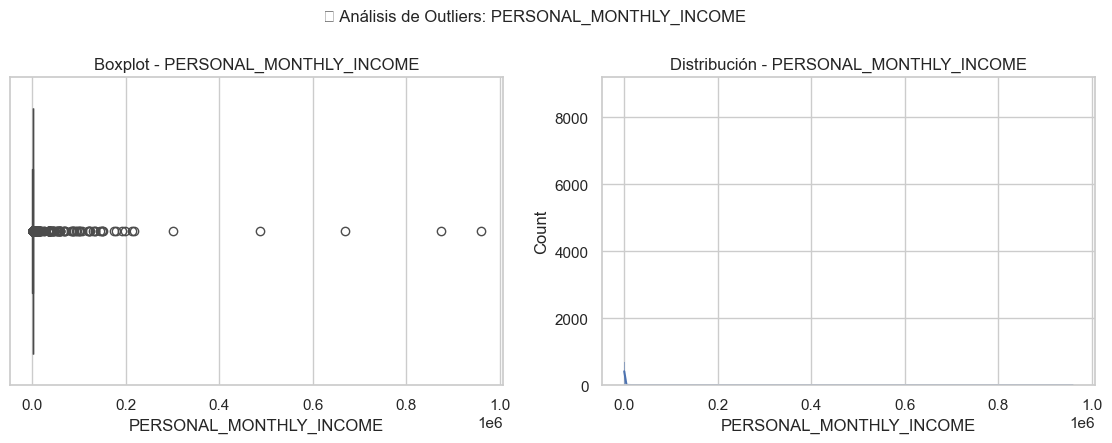

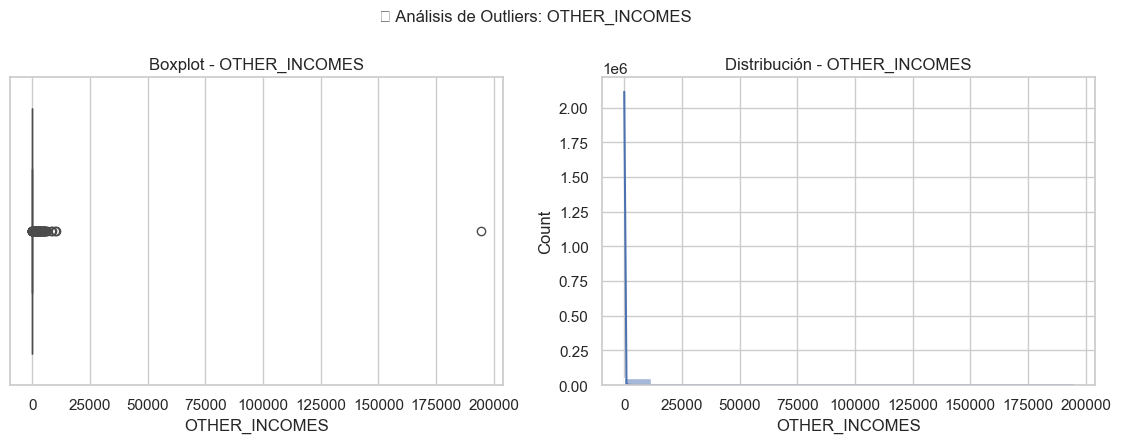

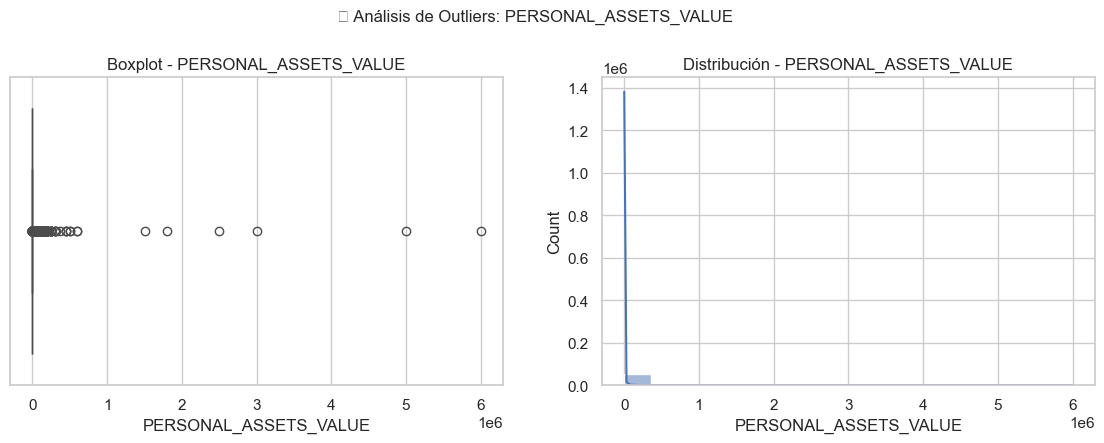

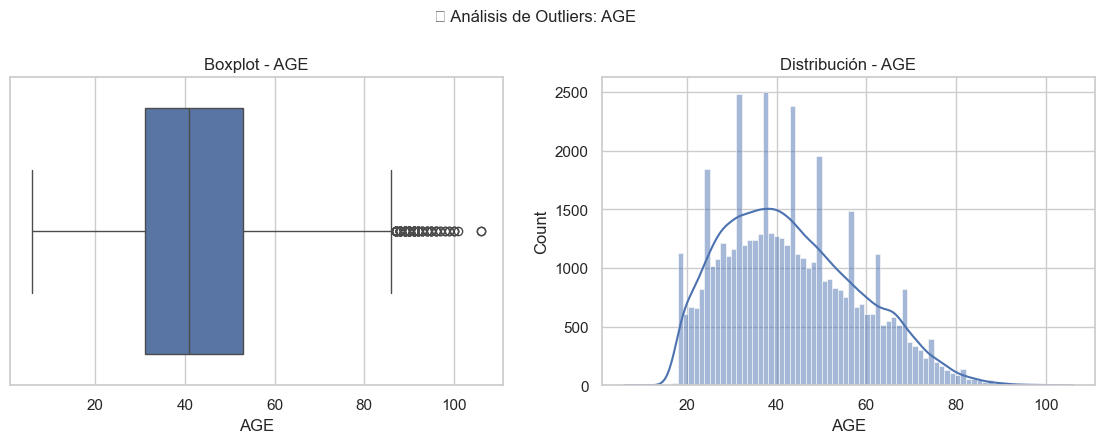

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo para gráficos
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 4)

print(f"📊 Variables numéricas reales a analizar: {len(num_reales)}\n")

for col in num_reales:
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    # Boxplot para detectar outliers
    sns.boxplot(x=df_eda[col], ax=axes[0])
    axes[0].set_title(f"Boxplot - {col}")

    # Histogram para ver distribución
    sns.histplot(df_eda[col], kde=True, ax=axes[1])
    axes[1].set_title(f"Distribución - {col}")

    plt.suptitle(f"📌 Análisis de Outliers: {col}", fontsize=12, y=1.05)
    plt.show()


In [22]:
import pandas as pd

print(f"📌 Variables numéricas reales: {len(num_reales)}\n")

stats = df_eda[num_reales].describe(percentiles=[0.01, 0.05, 0.95, 0.99]).T
stats = stats[['min','1%','5%','mean','95%','99%','max']]
stats


📌 Variables numéricas reales: 6



,min,1%,5%,mean,95%,99%,max
ID_CLIENT,1.0,500.99,2500.95,25000.500000,47500.05,49500.0100,50000.0
MONTHS_IN_RESIDENCE,0.0,0.00,0.00,9.727149,30.00,45.0000,228.0
PERSONAL_MONTHLY_INCOME,60.0,205.00,288.00,886.678437,1802.05,3678.2187,959000.0
OTHER_INCOMES,0.0,0.00,0.00,35.434760,150.00,800.0000,194344.0
PERSONAL_ASSETS_VALUE,0.0,0.00,0.00,2322.372380,0.00,50000.0000,6000000.0
AGE,6.0,18.00,22.00,43.248520,70.00,80.0000,106.0
